## Sentiment Analysis for hotel review data - Tensorflow, Keras
#### Yuye Sheng 2020.3

In [1]:
# I used Google colab to run the notebook
import os
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

path = "/content/drive/My Drive"
os.chdir(path)
os.listdir(path)

### Word embedding

In [2]:
# tokenize each review to a sequence and padding the sequence in order to have fixed length
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np

# load the cleaned data (i.e. data after data preprocessing), the file is the one saved in "Naive Bayes and SVM - Spark.ipynb"
df = pd.read_csv("Cleaned_hotel_review_data.csv")

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df["all_review"],df["label"],test_size=0.2,random_state=100)
y_train = y_train.to_numpy(dtype='int32') # the input of tensorflow model should be numpy
y_test = y_test.to_numpy(dtype='int32')

tokenizer = Tokenizer() # default setting: num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0
tokenizer.fit_on_texts(df["all_review"])  # fit tokenizer on all reviews in the dataset
vocab_size = len(tokenizer.word_index)+1   # word_index:{word:id},+1 since keras need a layer of 0 used for padding
print("Number of unique tokens(words): ",vocab_size-1) 
train_tokenized = tokenizer.texts_to_sequences(x_train)
test_tokenized = tokenizer.texts_to_sequences(x_test)

max_len = max([len(s.split()) for s in df["all_review"]])# the fixed length should be the (maximum) numOfWords of the longest review
train_padding = pad_sequences(train_tokenized, padding = 'post',maxlen = max_len) 
test_padding = pad_sequences(test_tokenized, padding='post',maxlen = max_len)
print(train_padding.shape) # (412590,733) 
print(test_padding.shape)  # (103148,733)

Number of unique tokens(words):  81294
(412590, 733)
(103148, 733)


In [0]:
# balance the training set using under-sampling
# select 15% positive data and all negative data
all_train = np.concatenate((train_padding,y_train[:,np.newaxis]),axis=1) # combine x(features) and y(labels)
all_train_neg = all_train[all_train[:,-1]==0]  # select all negative data
posi = all_train[all_train[:,-1]==1]
all_train_posi = posi[1000:round(posi.shape[0]*0.15)+1000]

posi_pad = np.concatenate((all_train_neg,all_train_posi),axis=0)
train_padding_ = posi_pad[:,:-1]  # final training set used for model training
y_train_= posi_pad[:,-1]

In [4]:
# download pre-trained GloVe model from their official website first and then run the following code
# compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:
embedding_index = {}
with open('glove.6B.100d.txt',encoding = 'utf-8') as f:  # we used dimension 100 of word vector
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')  
        embedding_index[word] = coefs
print('Found %s word vectors.'% len(embedding_index))

# leverage our embedding_index dictionary and our word_index to compute our embedding matrix:
EMBEDDING_DIM = 100  # the dimension of word vector 
embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM)) # words not found in embedding index will be all-zeros
for word,i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: # update embedding matrix if the word in the corpus exists in GloVe
        embedding_matrix[i] = embedding_vector

# look at how many words in our corpus were covered by GloVe
nonzero_words = np.count_nonzero(np.count_nonzero(embedding_matrix,axis=1))  
print(nonzero_words/vocab_size) 

# load this embedding matrix into an Embedding layer. Note that we set trainable=False to prevent the weights from being updated during training.
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(vocab_size,
                EMBEDDING_DIM, 
                weights = [embedding_matrix],
                input_length = max_len,
                trainable = False)

Found 400000 word vectors.
0.5263546343563564


In [0]:
# function of constructing the plots of confusion matrix
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## CNN

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPooling1D
model = Sequential()
model.add(embedding_layer)

model.add(Conv1D(filters=256,kernel_size=5,padding='same',activation='relu'))  
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

print(model.summary())
# compile 
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# fit 
history = model.fit(train_padding_,y_train_,validation_data =(test_padding,y_test),epochs=8,batch_size=128)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 733, 100)          8129500   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 733, 256)          128256    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 8,266,013
Trainable params: 136,513
Non-trainable params: 8,129,500
______________________________________

In [46]:
model.fit(train_padding_,y_train_,validation_data =(test_padding,y_test),epochs=1,batch_size=128)

764/764 [==============================] - 25s 33ms/step - loss: 0.3067 - accuracy: 0.8647 - val_loss: 0.2646 - val_accuracy: 0.8779


In [47]:
# retrieve predicted labels and compute the evaluation metrics
y_train_pred = model.predict_classes(train_padding)
y_test_pred = model.predict_classes(test_padding)

from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score
print(confusion_matrix(y_train, y_train_pred))
print(confusion_matrix(y_test, y_test_pred))
print("train metrics: ",precision_recall_fscore_support(y_train, y_train_pred))
print("test metrics: ",precision_recall_fscore_support(y_test, y_test_pred))
print("train accuracy: ",accuracy_score(y_train, y_train_pred))
print("test accuracy: ",accuracy_score(y_test, y_test_pred))

[[ 35340   6863]
 [ 38665 331722]]
[[ 8264  2293]
 [10298 82293]]
train metrics:  (array([0.4775353 , 0.97973035]), array([0.83738123, 0.89560919]), array([0.60821974, 0.93578308]), array([ 42203, 370387]))
test metrics:  (array([0.44521065, 0.9728915 ]), array([0.78279814, 0.88877969]), array([0.56760191, 0.92893547]), array([10557, 92591]))
train accuracy:  0.8896531665818367
test accuracy:  0.8779326792569899


Normalized confusion matrix
[[0.83738123 0.16261877]
 [0.10439081 0.89560919]]
Normalized confusion matrix
[[0.78279814 0.21720186]
 [0.11122031 0.88877969]]


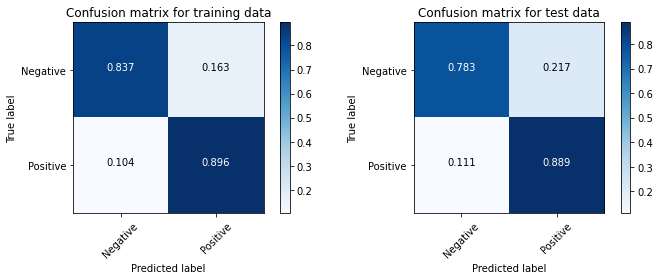

In [50]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), classes=["Negative","Positive"],normalize=True,
                      title='Confusion matrix for training data')

plt.subplot(122)
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=["Negative","Positive"],normalize=True,
                      title='Confusion matrix for test data')
plt.savefig("cnn_cm.png")
plt.show()
from google.colab import files
files.download("cnn_cm.png")

 ## GRU

In [51]:
# GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.layers import GRU,BatchNormalization,Bidirectional
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(GRU(128, dropout=0.5))) 
model.add(Dense(1,activation='sigmoid'))
print(model.summary())
# compile 
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# fit 
history = model.fit(train_padding_,y_train_,validation_data =(test_padding,y_test),epochs=10,batch_size=128)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 733, 100)          8129500   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               176640    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 8,306,397
Trainable params: 176,897
Non-trainable params: 8,129,500
_________________________________________________________________
None
Epoch 1/10
764/764 [==============================] - 115s 150ms/step - loss: 0.4745 - accuracy: 0.7633 - val_loss: 0.2981 - val_accuracy: 0.8632
Epoch 2/10
764/764 [==============================] - 114s 149ms/step - loss: 0.4031 - accuracy: 0.8122 - val_loss: 0.2548 - val_accuracy: 0.8907
Epoch 3/10
764/764 [==============================] - 114s 150ms/step -

In [55]:
# retrieve predicted labels and compute the evaluation metrics
y_train_pred = model.predict_classes(train_padding)
y_test_pred = model.predict_classes(test_padding)

from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score
print(confusion_matrix(y_train, y_train_pred))
print(confusion_matrix(y_test, y_test_pred))
print("train metrics: ",precision_recall_fscore_support(y_train, y_train_pred))
print("test metrics: ",precision_recall_fscore_support(y_test, y_test_pred))
print("train accuracy: ",accuracy_score(y_train, y_train_pred))
print("test accuracy: ",accuracy_score(y_test, y_test_pred))

[[ 34104   8099]
 [ 37805 332582]]
[[ 8368  2189]
 [ 9632 82959]]
train metrics:  (array([0.47426609, 0.97622703]), array([0.80809421, 0.89793108]), array([0.59772855, 0.93544359]), array([ 42203, 370387]))
test metrics:  (array([0.46488889, 0.97429182]), array([0.79264943, 0.89597261]), array([0.58605596, 0.93349237]), array([10557, 92591]))
train accuracy:  0.8887418502629729
test accuracy:  0.8853976810020553


Normalized confusion matrix
[[0.80809421 0.19190579]
 [0.10206892 0.89793108]]
Normalized confusion matrix
[[0.79264943 0.20735057]
 [0.10402739 0.89597261]]


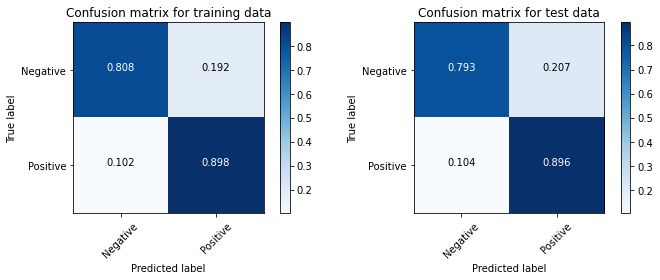

In [56]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), classes=["Negative","Positive"],normalize=True,
                      title='Confusion matrix for training data')

plt.subplot(122)
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=["Negative","Positive"],normalize=True,
                      title='Confusion matrix for test data')
plt.savefig('gru_cm.png')
plt.show()
from google.colab import files
files.download('gru_cm.png')